In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### 2a. Use the Kaggle Fake News Data Set

In [2]:
kag_train = pd.read_csv('./train_kaggle.csv',index_col=0)
kag_test = pd.read_csv('./test_kaggle.csv',index_col=0)

In [3]:
kag_train.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### 2b. Use the "Liar, Liar" DataSet from Politifact.com (3_liar_dataset.zip)

In [4]:
liar_df_train = pd.read_csv('./train.tsv',sep='\t',header=None)
liar_df_val = pd.read_csv('./valid.tsv',sep='\t',header=None)
liar_df_test = pd.read_csv('./test.tsv',sep='\t',header=None)

In [5]:
columns = ['ID','label','text','subjects','speaker','job','state','party','barely_true_count',
           'false_count','half_true_count','mostly_true_count','pants_on_fire_count','location']

In [6]:
liar_df_train.columns = columns
liar_df_val.columns = columns
liar_df_test.columns = columns

In [7]:
liar_df_train = liar_df_train.drop(labels=['ID'],axis=1)
liar_df_test = liar_df_test.drop(labels=['ID'],axis=1)
liar_df_val = liar_df_val.drop(labels=['ID'],axis=1)

In [8]:
liar_list = [liar_df_train,liar_df_val,liar_df_test]

In [9]:
liar_df_train.head(1)

,label,text,subjects,speaker,job,state,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,location
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer


As one can see, the features of the two datasets are quite different. Kaggle dataset is large, but does not provide the credit score of the speaker, venue, state, etc. Most of the analysis will be run on the Liar dataset, while one of the steps will be merging the datasets and investigating the generalization of the model. All the engineered features are used in further tasks, however "credit score" is not, since it has a look-ahead bias (no time stamps provided in the dataset).

In [10]:
import pandas_profiling

In [11]:
pandas_profiling.ProfileReport(liar_df_train)

Number of variables,13
Number of observations,10240
Total Missing (%),3.9%
Total size in memory,1.0 MiB
Average record size in memory,104.0 B
Numeric,2
Categorical,8
Boolean,0
Date,0
Text (Unique),0
Rejected,3


As one can see, there are features with a couple of values dominating and a large number of distinct numbers at the same time. It gives a good ground for feature engineering. 
Top N frequent features of states, subjects, speaker and party will be one-hot-encoded. One-hot encoding is used instead of direct transformation to a single numerical feature to avoid introducing artificial relations between values (example: obama=1, trump=2, putin=3 -> trump is closer to putin (3-2), than obama to putin (3-1), which is not necessarily true). 

### 2d. Define factors in a polynomial equation for factors constituting "Fake News/ Factual News": e.g., Reliable Source, Political Affiliation, Sensationalism, Echo Chamber

Encoding the above mentioned features with one-hot-encoding. <br>

The reliable source would be represented by location and speaker features<br>
Political affiliation - by party<br>
Echo chamber - by state and subject (based on the definition of the Echo chamber from the paper)<br>
Sensationalism - may be represented by a topic and a speaker<br>
<br>
It should be noted that these factors are not directly present in the dataset (besides a party) and may be derived from the present features 

Polynomial equation here is addressed as a general approach of estimators, SHAP values and random forest feature importances are used to rank features and investigate their effects, The above-mentioned factors may be derived from them based on the provided descriptions

In [12]:
n = 10

In [13]:
states = liar_list[0].groupby(['state']).count().label.sort_values(ascending=False)[:n].index.tolist()
subjects = liar_list[0].groupby(['subjects']).count().label.sort_values(ascending=False)[:n].index.tolist()
speaker = liar_list[0].groupby(['speaker']).count().label.sort_values(ascending=False)[:n].index.tolist()
party = liar_list[0].groupby(['party']).count().label.sort_values(ascending=False)[:n].index.tolist()
location = liar_list[0].groupby(['location']).count().label.sort_values(ascending=False)[:n].index.tolist()
job = liar_list[0].groupby(['job']).count().label.sort_values(ascending=False)[:n].index.tolist()

In [14]:
#features_of_interest - set of binary features to be used in the classification
features_of_interest = states+subjects+speaker+party+location+job
to_encode = [('speaker',speaker),
            ('party',party),
            ('subjects',subjects),
            ('state',states),
            ('location',location),
            ('job',job)]
for i in liar_list:
    for var in to_encode:
        for value in var[1]:
            i[value] = i[var[0]].apply(lambda x: x==value)

In [15]:
liar_df_train.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [16]:
truth = {'false':0.,'half-true':0.5,'mostly-true':0.75,'true':1.,'pants-fire':-0.25,'barely-true':0.25} 

In [17]:
for i in liar_list:
    i['numer_truth'] = i['label'].apply(lambda x: truth[x])

Additionally, sensationalism may be related with extra-positive or -negative claims. Consequently, sentiment analysis would give us an indirect way of evaluating the sensationalism factor. 

In [18]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

Since sentiment takes into account punctiation and upper-case letters, no punctuation is removed prior to applying it.

In [19]:
import string
import nltk
from nltk import PorterStemmer
import re 
#nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_stem (sent, seq=False):
    temp1=sent
    temp2 = re.split('\W+',temp1)
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3
def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']

In [20]:
for i in liar_list:
    i['sentiment'] = i['text'].apply(lambda x: sentiment(' '.join(clean_stem(x))))

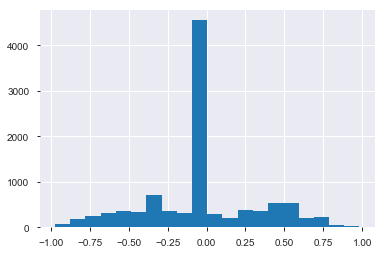

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(liar_list[0].sentiment.values.tolist(),bins=20)
plt.show()

In [22]:
features_of_interest = features_of_interest+['sentiment']

### 2e. Create 2 classification models that assess at least three of these factors and create corresponding weights for your polynomial equation for coming up with a Fake News score.

In [23]:
X_train = liar_list[0][features_of_interest]#.values
X_val = liar_list[1][features_of_interest]#.values
X_test = liar_list[2][features_of_interest]#.values

y_train = liar_list[0]['numer_truth'].values
y_val = liar_list[1]['numer_truth'].values
y_test = liar_list[2]['numer_truth'].values

After the truth was transformed into a numerical value and a set of binary features was generated, either classification or regression task may be set up. First we srart from a classification task:

In [24]:
y_train_bin = y_train.copy()
y_train_bin[y_train_bin >= 0.75] = 1
y_train_bin[y_train_bin < 0.75] = 0

y_val_bin = y_val.copy()
y_val_bin[y_val_bin >= 0.75] = 1
y_val_bin[y_val_bin < 0.75] = 0

y_test_bin = y_test.copy()
y_test_bin[y_test_bin >= 0.75] = 1
y_test_bin[y_test_bin < 0.75] = 0

Here we can try two different set ups - classification (>=0.75 truth is true) and regression.
Also, it might be interesting to compare two classifiers.

Since the data is imbalanced, it is important to take this into account, when building a model. One of the ways of doing it is adding class weights. Other approaches involve down-scaling (cons: loosing samples) and up-scaling (cons: generating high-quality multidimentional samples is an advanced task). The two classifiers could be XGboost (advanced version of RandomForest) and SVM, supporting class weights.
https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

In [36]:
import xgboost
import shap
from sklearn.ensemble import RandomForestClassifier

In [26]:
classy_1 = xgboost.XGBClassifier()
classy_1 = classy_1.fit(X_train,y_train_bin)

In [27]:
classy_1.predict(X_val.iloc[[0],:])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0.])

SHAP values will be used to understand the feature influence:
https://github.com/slundberg/shap

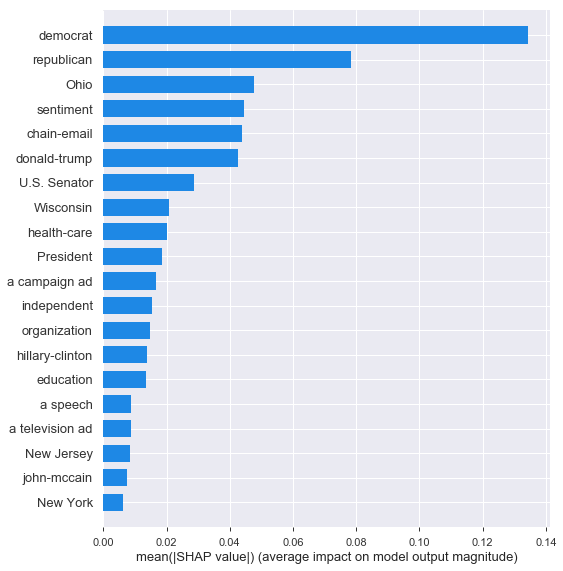

In [40]:
shap.initjs()
explainer = shap.TreeExplainer(classy_1)

#getting SHAP values for the validation dataset
shap_values = explainer.shap_values(X_val)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])
shap.summary_plot(shap_values, X_val, plot_type="bar")

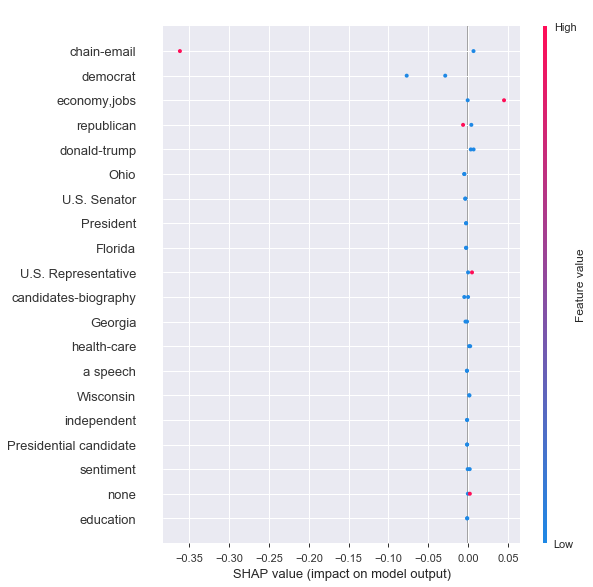

In [49]:
shap.summary_plot(shap_values[:2,:], X_val.iloc[:2,:])

These are feature weights for a particular entry. In this case belonging to a republican party, not belonging to democrats, talking not in Ohio, being not a U.S. Senator or a President 'pushes' the output closer to 0 (fake statement), at the same time being not donald-trump, having zero sentiment and being not a chain-email form of statement 'pushes' the statement in the direction of truth. 
This can be done for the whole dataset

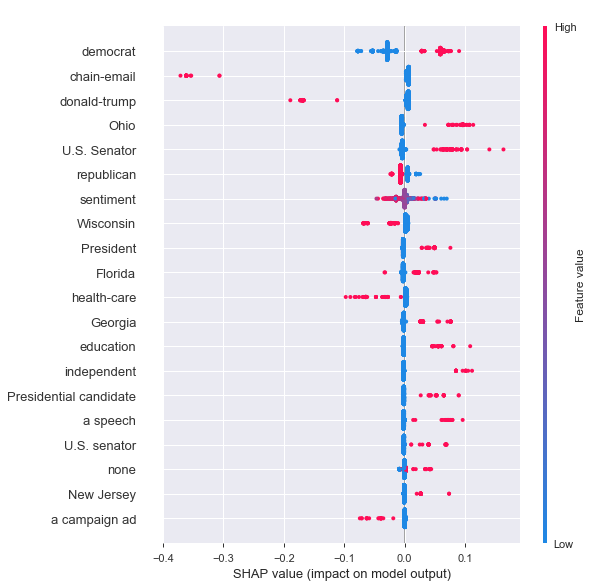

In [50]:
shap.summary_plot(shap_values, X_val)

In [42]:
#shap.force_plot(explainer.expected_value, shap_values[:15,:], X_val.iloc[:15,:])

Repeating these steps for the regression task.

In [43]:
classy_2 = xgboost.XGBRegressor()
classy_2 = classy_2.fit(X_train,y_train)

In [44]:
classy_2.predict(X_val.iloc[[0],:])

array([0.44037703], dtype=float32)

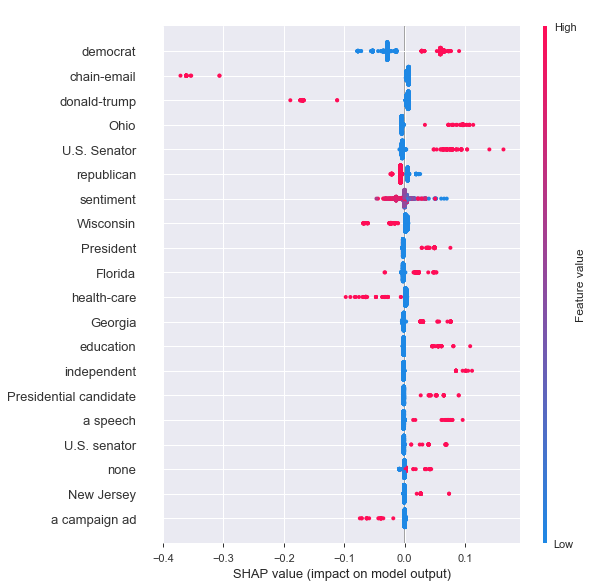

In [45]:
explainer = shap.TreeExplainer(classy_2)
shap_values = explainer.shap_values(X_val)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])
shap.summary_plot(shap_values, X_val)

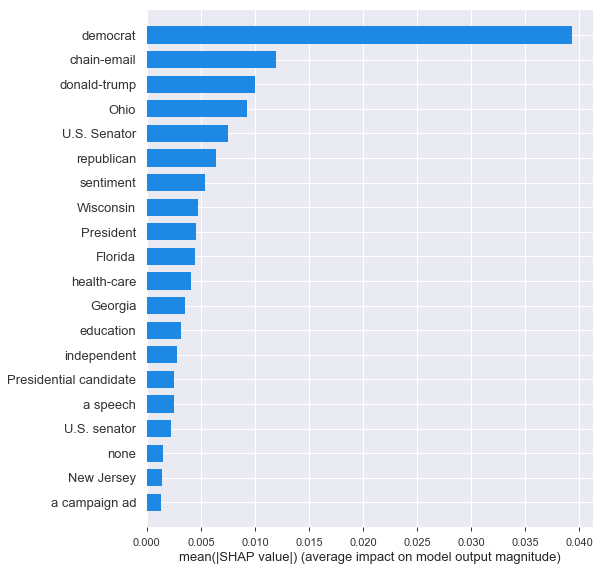

In [46]:
#shap.force_plot(explainer.expected_value, shap_values[:15,:], X_val.iloc[:15,:])
shap.summary_plot(shap_values, X_val, plot_type="bar")

Now let us get performances for both XGBoost and SVM and compare their performances. To address the class imbalance problem, classification task is chosen. F1 score will be used as a comparison metric, since it takes into account true nagatives, positives as well as false negatives and positives. Since validation data was already used (introducing bias), test data will be used for the comparison

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [48]:
np.sum(y_train_bin==0)/np.sum(y_train_bin==1)

1.8147333699835073

In [49]:
svm = SVC(class_weight = 'balanced')
xg_bal = xgboost.XGBClassifier(scale_pos_weight=np.sum(y_train_bin==0)/np.sum(y_train_bin==1))
xg = xgboost.XGBClassifier()

In [50]:
svm = svm.fit(X_train,y_train_bin)
xg = xg.fit(X_train,y_train_bin)
xg_bal = xg_bal.fit(X_train,y_train_bin)

In [326]:
y_pred_svm = svm.predict(X_test)
y_pred_xg = xg.predict(X_test)
y_pred_xg_bal = xg_bal.predict(X_test)

In [52]:
print('F1_score of imbalanced XGBoostClassifier: {}'.format(f1_score(y_true=y_test_bin,y_pred=y_pred_xg)))

F1_score of imbalanced XGBoostClassifier: 0.13051823416506717


In [53]:
print('F1_score of balanced XGBoostClassifier: {}'.format(f1_score(y_true=y_test_bin,y_pred=y_pred_xg_bal)))

F1_score of balanced XGBoostClassifier: 0.4907216494845361


In [54]:
print('F1_score of SVC: {}'.format(f1_score(y_true=y_test_bin,y_pred=y_pred_svm)))

F1_score of SVC: 0.458980044345898


The conclusion is that, even while XGBoost is a powerful tool, it does not work without the imbalance mitigation techniques. Permutation tests show that the developed model performes significantly better than random.

Perfutation test below is aimed to show the performance of the developed model versus random. It should be noted that XGBoost is an estimator of a stochastic nature. To be sure about the result, it might be useful to get an average performance and its standard deviation on multiple runs. The results below were validated at least 10 time - the performance is consistent. 

F1 score 0.5964760893812727 (pvalue : 0.009900990099009901)


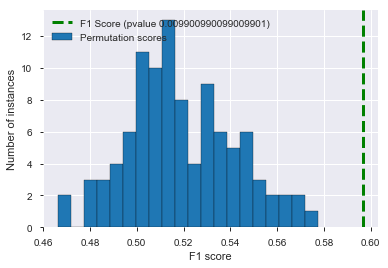

In [327]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
cv = StratifiedKFold(2)

score, permutation_scores, pvalue = permutation_test_score(
    xg_bal, X_test, y_test_bin, scoring="f1_weighted", cv=cv, n_permutations=100, n_jobs=3)

print("F1 score %s (pvalue : %s)" % (score, pvalue))


plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='F1 Score'
         ' (pvalue %s)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('F1 score')
plt.ylabel('Number of instances')
plt.show()

To get the feature importances, xgboost best estimator is analysed:

In [328]:
fscore = xg_bal.feature_importances_

Features sorted by importance, from high to low. One can see that sentiment has a significant influence, as well as the form of the communication (chain-email, tweet). Seems that speakers do not lie in their biograhies. The fact of being Trump influences the result strongly. Interestingly, there is a pattern connected with Ohio state. The reason is most probably very high class imbalance for this particular state, deriving from the sample bias, rather than a real behavior pattern.  

In [63]:
X_train.columns.values[np.argsort(fscore)[::-1]]

array(['sentiment', 'chain-email', 'candidates-biography', 'U.S. Senator',
       'Ohio', 'a tweet', 'health-care', 'donald-trump', 'a campaign ad',
       'republican', 'Wisconsin', 'education', 'hillary-clinton',
       'democrat', 'President', 'independent', 'taxes', 'organization',
       'a television ad', 'a speech', 'none', 'New Jersey',
       'federal-budget', 'john-mccain', 'elections', 'scott-walker',
       'U.S. senator', 'Florida', 'newsmaker', 'a TV ad', 'economy',
       'columnist', 'a news release', 'Georgia', 'a press release',
       'Texas', 'an interview', 'Rhode Island', 'Illinois', 'Senator',
       'barack-obama', 'New York', 'a radio interview',
       'Presidential candidate', 'rick-perry', 'guns', 'journalist',
       'immigration', 'Virginia', 'Governor',
       'Milwaukee County Executive', 'libertarian', 'U.S. Representative',
       'President-Elect', 'Former governor', 'mitt-romney', 'a debate',
       'marco-rubio', 'rick-scott', 'activist', 'economy,j

### 2f. Conduct LDA on the three DataSets above and visualize. Interpret results in a Data Narrative; e.g. what are the topics in those data sets?

The LDA will be performed on the test parts of the datasets, due to computational resources limitation. Only english news were considered for the Kaggle dataset

In [92]:
from langdetect import detect
from langdetect import detect_langs

In [329]:
def clean_stem (sent, seq=False):
    try:
        lang = detect(sent)
    except:
        return []
    if lang != 'en':
        return []
    temp1 ="".join(x for x in sent if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3
kag_test['tokens'] = kag_test['text'].apply(lambda x: clean_stem(x))

In [113]:
nested_ls_kag = kag_test.tokens.values.tolist()

In [114]:
from gensim import corpora
dictionary = corpora.Dictionary(nested_ls_kag)

In [115]:
corpus = [dictionary.doc2bow(text) for text in nested_ls_kag]

In [116]:
import gensim
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5_kag.gensim')
topics = ldamodel.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.012*"said" + 0.011*"state" + 0.010*"law" + 0.008*"court" + 0.007*"feder" + 0.006*"govern" + 0.005*"immigr"')
(1, '0.009*"us" + 0.009*"world" + 0.007*"china" + 0.007*"state" + 0.006*"govern" + 0.005*"power" + 0.005*"system"')
(2, '0.011*"compani" + 0.009*"year" + 0.009*"percent" + 0.009*"said" + 0.007*"market" + 0.006*"million" + 0.006*"tax"')
(3, '0.018*"abort" + 0.017*"women" + 0.008*"babi" + 0.006*"state" + 0.006*"birth" + 0.004*"alabama" + 0.004*"pregnanc"')
(4, '0.026*"polic" + 0.017*"protest" + 0.009*"peopl" + 0.009*"water" + 0.008*"report" + 0.007*"arrest" + 0.007*"offic"')
(5, '0.010*"use" + 0.007*"dr" + 0.006*"drug" + 0.005*"peopl" + 0.005*"one" + 0.005*"also" + 0.005*"like"')
(6, '0.058*"mr" + 0.037*"said" + 0.007*"ms" + 0.006*"year" + 0.005*"countri" + 0.005*"offici" + 0.005*"new"')
(7, '0.012*"said" + 0.007*"one" + 0.006*"like" + 0.006*"time" + 0.005*"ms" + 0.005*"year" + 0.005*"new"')
(8, '0.011*"univers" + 0.011*"art" + 0.011*"us" + 0.009*"retir" + 0.008*"gener" + 0

In [117]:
dictionary.save('dictionary_kag.gensim')

In [118]:
import pickle
pickle.dump(corpus, open('corpus_kag.pkl', 'wb'))

In [330]:
dictionary = gensim.corpora.Dictionary.load('dictionary_kag.gensim')
corpus = pickle.load(open('corpus_kag.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5_kag.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Interpretation of the topics: 

0) Law topic, related also to immigration, government, states (courts)<br>
1) US-China talks<br>
2) Market state, taxes<br>
3) Abortions<br>
4) Protests and arrests<br>
5) drugs<br>
6) *hard to interpert*<br>
7) Interviews (mr said - high frequencies (see the visualization))<br>
8) Art and museums<br>
9) President topc<br>
10) Syria war<br>
11) *hard to interpert*<br>
12) Elections - republicans/democrats<br>
13) Israel-related<br>
14) Investigation of the Trump election campaign<br>

In [331]:
def clean_stem_liar (sent, seq=False):
    temp1 ="".join(x for x in sent if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3
liar_list[0]['tokens'] = liar_list[0]['text'].apply(lambda x: clean_stem(x))
nested_ls_liar = liar_list[0].tokens.values.tolist()

dictionary = corpora.Dictionary(nested_ls_liar)
corpus = [dictionary.doc2bow(text) for text in nested_ls_liar]

In [ ]:
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5_liar.gensim')
topics = ldamodel.print_topics(num_words=7)
for topic in topics:
    print(topic)

dictionary.save('dictionary_liar.gensim')
pickle.dump(corpus, open('corpus_liar.pkl', 'wb'))

In [332]:
dictionary = gensim.corpora.Dictionary.load('dictionary_liar.gensim')
corpus = pickle.load(open('corpus_liar.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5_liar.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Interpretation of the topics: 

0) Taxes <br>
1) Healthcare, Obamacare <br>
2) Voting <br>
3) Historical topics, Iraq war<br>
4) Job market<br>
5) California education<br>
6) Clinton-Trump<br>
7) Market state (?)<br>
8) State politics<br>
9) State voting<br>
10) Presidents<br>
11) Guns<br>
12) Budget, funds, taxes<br>
13) Wisconsin, republican party <br>
14) Wages, debt<br>

### 2g. Conduct some form of regression analysis (open for your innovation) 
#### 2g1. Given news can we predict what a politician will say?
Not having time stamps, it might be hard to predict, what a politician will say, since there is no notion of time in the dataset. However, we could try predicting the LDA topic based on the set of features developed in the previous part. The underlying assumption is that certain information sources/political parties/speakers tend to be focused on a particular topic

In order to do so, LDA topics for each entry are indentified. This is done for both training and test parts of the dataset. Then the model is trained on the training part of the dataset and the performance is measured using the test part

In [154]:
for i in range(3):
    liar_list[i]['tokens'] = liar_list[i]['text'].apply(lambda x: clean_stem(x))
    liar_list[i]['LDA_representation'] = liar_list[i]['tokens'].apply(lambda x: dictionary.doc2bow(x))
    liar_list[i]['topic_vector'] = liar_list[i]['LDA_representation'].apply(lambda x: ldamodel[x])
    liar_list[i]['topic'] = liar_list[i]['topic_vector'].apply(lambda x: max(dict(x).items(), key=operator.itemgetter(1))[0])

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
clf_svm = SVC(class_weight='balanced')
clf = RandomForestClassifier()
y_train_lda = liar_list[0].topic.tolist()
y_tests_lda = liar_list[2].topic.tolist()
clf = clf.fit(X_train,y_train_lda)
clf_svm = clf_svm.fit(X_train,y_train_lda)

In [162]:
y_pred = clf.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
print('F1 score for RandomForest classifier without class balancing: {}'.format(f1_score(y_true=y_tests_lda,y_pred=y_pred,average='weighted')))
print('F1 score for SVM classifier with class balancing: {}'.format(f1_score(y_true=y_tests_lda,y_pred=y_pred_svm,average='weighted')))

F1 score for RandomForest classifier without class balancing: 0.16103017625831575
F1 score for SVM classifier with class balancing: 0.1605351368443112


Text(30.5,0.5,'topic number')

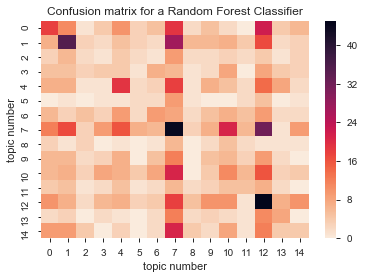

In [168]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true=y_tests_lda, y_pred=y_pred, labels=range(0,15), sample_weight=None),cmap = sns.cm.rocket_r)
plt.title('Confusion matrix for a Random Forest Classifier')
plt.xlabel('topic number')
plt.ylabel('topic number')

Text(30.5,0.5,'topic number')

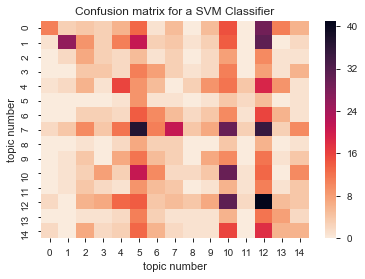

In [167]:
sns.heatmap(confusion_matrix(y_true=y_tests_lda, y_pred=y_pred_svm, labels=range(0,15), sample_weight=None),cmap = sns.cm.rocket_r)
plt.title('Confusion matrix for a SVM Classifier')
plt.xlabel('topic number')
plt.ylabel('topic number')

While Random Forest can reliably predict at least 3 topics, SVM has pretty serious preformance issues, which are not so obvious from the f1 scores, but clearly seen on the confusion matrix. 
Concluding: 2,7,12 topics may be defined based on the binary string of features. 

These topics are: <br>
2) Voting <br>
7) Market state (?)<br>
12) Budget, funds, taxes<br>

It should be pointed out that there might be bias due to encoding subjects in these binary features. However, top important features below show that this is not necessarly the case, since top 10 important features do not contain anything exclusively related to these topics. 

In [170]:
X_train.columns.values[np.argsort(clf.feature_importances_)[::-1]]

array(['sentiment', 'Florida', 'Texas', 'health-care', 'democrat',
       'a press release', 'U.S. Senator', 'Georgia', 'republican',
       'Wisconsin', 'an interview', 'a speech', 'a tweet',
       'a news release', 'Virginia', 'economy', 'U.S. Representative',
       'Governor', 'taxes', 'elections', 'none', 'immigration', 'Ohio',
       'a TV ad', 'New Jersey', 'a radio interview', 'a debate',
       'a campaign ad', 'guns', 'Senator', 'a television ad',
       'candidates-biography', 'Rhode Island', 'organization',
       'federal-budget', 'independent', 'U.S. senator', 'education',
       'New York', 'economy,jobs', 'Illinois', 'chain-email', 'newsmaker',
       'journalist', 'activist', 'rick-perry', 'libertarian',
       'marco-rubio', 'Milwaukee County Executive', 'columnist',
       'mitt-romney', 'john-mccain', 'President',
       'Presidential candidate', 'rick-scott', 'barack-obama',
       'Former governor', 'scott-walker', 'President-Elect',
       'donald-trump', 'hilla

### 2g2. Given a news story, break it into its constituent fake/alternative parts

There is a variety of ways to address this challenge. The most accurate and computationally intensive is optimization of the chunk size for each claim. Due to limited comutational resources, I would split the messages into n=4 parts, perform the bag of words approach and evaluate each part separately.

Investigating the estimator confidence, I could introduce a threshold to separate artificial findings from the real results.

The estimator will be fitted on the training dataset, without any splitting. Then the splitted input will be evaluated

In [172]:
#creating and fitting a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectstem = TfidfVectorizer(analyzer=clean_stem)

Stemmed - 9458


### Preparing training dataset based on Liar

In [273]:
kag_train.shape

(20800, 4)

I decrease a size of the training dataset, taking around 11% of it, in order to make the model trained faster (xboost). If You change the model to RandomForest, You would be able to fit it fast on a multicore machine, using n_jobs = -1. 

In [ ]:
train_test_split = -200 # index for training abs(value) - number of samples used for testing

In [ ]:
training_ds = kag_train.iloc[:train_test_split] #liar_list[0]
textfeatures=vectstem.fit_transform(training_ds['text'])
print("Stemmed - " + str(len(vectstem.get_feature_names())))

In [275]:
tfidf_feats = pd.DataFrame(textfeatures.toarray(),index = training_ds.index,columns=vectstem.vocabulary_)

In [302]:
training_ds = training_ds.rename(columns={'label':'score_label_y'})

In [303]:
kag_train = kag_train.rename(columns={'label':'score_label_y'})

In [304]:
tf_idf_dataset_train = pd.concat([tfidf_feats,training_ds['score_label_y']],axis=1) #'numer_truth' - if using liar_list

#### Selecting a dataset for creating chunks

In [305]:
liar_list[2]['size'] = liar_list[2]['tokens'].apply(lambda x: len(x))

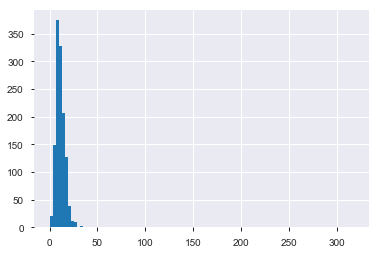

In [306]:
plt.hist(liar_list[2]['size'],bins=100)
plt.show()

Seems that liar dataset consists of relatively short claims, which can hardly be split into chunks. Let's look at the length distribution of the kaggle dataset

In [307]:
kag_train.columns

Index(['title', 'author', 'text', 'score_label_y'], dtype='object')

In [333]:
kag_test = kag_train.iloc[train_test_split:]
kag_test['tokens'] = kag_test['text'].apply(lambda x: clean_stem(x))

In [334]:
kag_test['size'] = kag_test['tokens'].apply(lambda x: len(x))

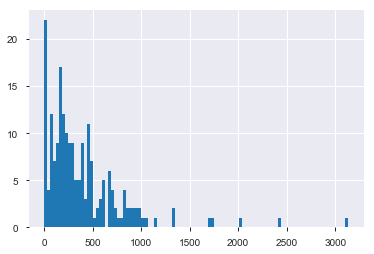

In [310]:
plt.hist(kag_test['size'],bins=100)
plt.show()

##### Seems to be way more suitable for splitting!
Let's perform training on liar, testing on kaggle. This way we will investigate the model's generalization 

In [ ]:
def splitter(token_list,chunk=1,n=4):
    size = len(token_list)
    chunk_size = int(size/n)
    return token_list[(chunk-1)*chunk_size:(chunk)*chunk_size]

In [ ]:
n = 4

In [356]:
for i in range(n):
    kag_test['chunk_'+str(i)] = kag_test['tokens'].apply(lambda x: ' '.join(splitter(x,chunk=i+1,n=n)))

In [357]:
kag_test['chunk_1'].iloc[0]

'due threat rabid support feel backlash trump support scare us intimid us fear live said mindi mcgillivray said trump grope parti look window car drive around hous look slow right hous live gate commun danger could peopl want hurt us pressur stay silent come strong trump camp look michael cohen special counsel trump organ respond daili beast call ask comment stori trump rape thenwif ivana trump'

In [358]:
kag_test['chunk_2'].iloc[0]

'pain brutal fashion make sure meet one day courthous take everi penni still come daili beast everybodi els possibl know warn tread fuck lightli go go fuck disgust understand write stori mr trump name word rape go mess life long frickin planet go judgment much money never know get underneath beg question defens noth hide mr trump donald trump follow lowest hate scum ever tarnish american'

In [359]:
text_features_chunks = []
for i in range(n):
    text_features_chunks.append(vectstem.transform(kag_test['chunk_'+str(i)]))

In [360]:
chunk_list = []
for i in range(n):
    chunk_list.append(pd.DataFrame(text_features_chunks[i].toarray(),index = kag_test.index,columns=vectstem.vocabulary_))

In [361]:
chunk_datasets = []
for i in chunk_list:
    chunk_datasets.append(pd.concat([i,kag_test['score_label_y']],axis=1))

kaggle (or Liar) labels should be inverted if using both datasets here, since 1 represents fake and 0 - reliable news.

In [319]:
x_train = tf_idf_dataset_train.drop(labels=['score_label_y'],axis=1) #'numer_truth'
y_train = tf_idf_dataset_train['score_label_y']
# y_train[y_train>=0.75] = -1 # inverting labels to match kaggle
# y_train[y_train<0.75] = 1
# y_train[y_train==-1] = 0

clf = xgboost.XGBClassifier(scale_pos_weight=np.sum(y_train.values==0)/np.sum(y_train.values==1))

In [320]:
clf = clf.fit(x_train,y_train.values)

In [363]:
counter = 0
for i in chunk_datasets:
    x_test = i.drop(labels=['score_label_y'],axis=1)
    y_test = i['score_label_y'].values
    y_pred = clf.predict(x_test)
    print('F1 score for classifying chunk {} is {}'.format(counter, f1_score(y_pred=y_pred,y_true=y_test,average='weighted')))
    counter+=1

F1 score for classifying chunk 0 is 0.7688351697149676
F1 score for classifying chunk 1 is 0.8128
F1 score for classifying chunk 2 is 0.7777804239104549
F1 score for classifying chunk 3 is 0.8628018948512852


The model was validated for both datasets - training was performed first on the Liar dataset, then on the Kaggle. Testing was always performed on Kaggle, since the texts are longer there. 
The results are the following:<br><br>
If the model is trained on the Liar dataset, there is no differens of the performance between chunks, meaning that the encoding vocabulary is probably not large enough (Liar dataset has smaller vocabulary). Basically, it is better not to generalize the model that way - the dataset formats are too different for a proper generalization.<br><br>
If the model is trined on the kaggle dataset, the results differ from chunk to chunk. Concretely: the beginning of the message is the least representative part (the prediction does not agree with the actual label of the message), while the end of the message agrees with the overall idea. The result may be evaluated from the perspective of the psychological manipulation techniques.   